**Project Overview**
* Objective: Predict the number of available drivers in a specific area over the next few hours using past data.

* Use Case: Helps ride-hailing services balance supply and demand.

1. Import the necessary libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2. Load the data

In [35]:
url ="https://raw.githubusercontent.com/jedidahwavinya/Machine-Learning/refs/heads/main/driver_availability.csv"
df = pd.read_csv(url)
df.describe()

,area_id,available_drivers
count,4251.000000,4251.000000
mean,102.000000,14.494001
std,0.816593,6.383888
min,101.000000,0.000000
25%,101.000000,9.000000
50%,102.000000,14.000000
75%,103.000000,20.000000
max,103.000000,32.000000


3. Perform EDA

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   datetime           4251 non-null   object
 1   area_id            4251 non-null   int64 
 2   available_drivers  4251 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 99.8+ KB


In [37]:
display(df.head())

,datetime,area_id,available_drivers
0,6/1/2025 0:00,101,9
1,6/1/2025 1:00,101,8
2,6/1/2025 2:00,101,10
3,6/1/2025 3:00,101,12
4,6/1/2025 4:00,101,8


4. Data Preprocessing

Convert datetime to datetime type

In [38]:
df['datetime'] = pd.to_datetime(df['datetime'])
display(df.head())

,datetime,area_id,available_drivers
0,2025-06-01 00:00:00,101,9
1,2025-06-01 01:00:00,101,8
2,2025-06-01 02:00:00,101,10
3,2025-06-01 03:00:00,101,12
4,2025-06-01 04:00:00,101,8


Resample data into hourly/daily intervals

In [39]:
# Resample to daily intervals (example)
# You can change 'D' to 'H' for hourly, 'W' for weekly, etc.
daily_df = df.set_index('datetime').resample('D').agg({
    'area_id': 'first',
    'available_drivers': 'sum'
}).reset_index()

display(daily_df.head())

,datetime,area_id,available_drivers
0,2025-06-01,101,967
1,2025-06-02,101,1052
2,2025-06-03,101,1073
3,2025-06-04,101,1102
4,2025-06-05,101,1078


5. Handle missing values (fill or drop)

In [40]:
# Check for missing values
print("Missing values before handling:")
print(daily_df.isnull().sum())

Missing values before handling:
datetime             0
area_id              0
available_drivers    0
dtype: int64


In [41]:
# Fill missing values with the mean
daily_df.fillna(daily_df.mean(), inplace=True)

print("\nMissing values after handling:")
print(daily_df.isnull().sum())


Missing values after handling:
datetime             0
area_id              0
available_drivers    0
dtype: int64


In [42]:
# Display info to check for missing values
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           60 non-null     datetime64[ns]
 1   area_id            60 non-null     int64         
 2   available_drivers  60 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.5 KB


6. Normalize or scale data (for neural nets)

In [43]:
# Select the column to scale
data_to_scale = daily_df[['available_drivers']]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(data_to_scale)

# Add the scaled data back to the DataFrame (optional, depending on how you'll use it)
daily_df['available_drivers_scaled'] = scaled_data

display(daily_df.head())

,datetime,area_id,available_drivers,available_drivers_scaled
0,2025-06-01,101,967,-0.421079
1,2025-06-02,101,1052,0.176446
2,2025-06-03,101,1073,0.324069
3,2025-06-04,101,1102,0.527931
4,2025-06-05,101,1078,0.359218


7. Feature Engineering
* Lag features: Past availability values

In [44]:
# Create lag features
daily_df['lag_1'] = daily_df['available_drivers_scaled'].shift(1)
daily_df['lag_2'] = daily_df['available_drivers_scaled'].shift(2)
daily_df['lag_3'] = daily_df['available_drivers_scaled'].shift(3)

display(daily_df.head())

,datetime,area_id,available_drivers,available_drivers_scaled,lag_1,lag_2,lag_3
0,2025-06-01,101,967,-0.421079,NaN,NaN,NaN
1,2025-06-02,101,1052,0.176446,-0.421079,NaN,NaN
2,2025-06-03,101,1073,0.324069,0.176446,-0.421079,NaN
3,2025-06-04,101,1102,0.527931,0.324069,0.176446,-0.421079
4,2025-06-05,101,1078,0.359218,0.527931,0.324069,0.176446


* Time features: Hour, Day of Week, etc.

In [45]:
# Extract time features
daily_df['hour'] = daily_df['datetime'].dt.hour
daily_df['dayofweek'] = daily_df['datetime'].dt.dayofweek
daily_df['dayofyear'] = daily_df['datetime'].dt.dayofyear
daily_df['month'] = daily_df['datetime'].dt.month
daily_df['year'] = daily_df['datetime'].dt.year

display(daily_df.head())

,datetime,area_id,available_drivers,available_drivers_scaled,lag_1,lag_2,lag_3,hour,dayofweek,dayofyear,month,year
0,2025-06-01,101,967,-0.421079,NaN,NaN,NaN,0,6,152,6,2025
1,2025-06-02,101,1052,0.176446,-0.421079,NaN,NaN,0,0,153,6,2025
2,2025-06-03,101,1073,0.324069,0.176446,-0.421079,NaN,0,1,154,6,2025
3,2025-06-04,101,1102,0.527931,0.324069,0.176446,-0.421079,0,2,155,6,2025
4,2025-06-05,101,1078,0.359218,0.527931,0.324069,0.176446,0,3,156,6,2025


8. Modeling:
* Multistep Time Series Forecasting

Deep Learning-Based Multistep Models
LSTM

In [57]:
# Drop rows with NaN values created by lag features
daily_df_cleaned = daily_df.dropna().copy()

In [58]:
# Define features (X) and target (y)
features = ['available_drivers_scaled', 'lag_1', 'lag_2', 'lag_3', 'hour', 'dayofweek', 'dayofyear', 'month', 'year']
target = 'available_drivers_scaled'

X = daily_df_cleaned[features].values
y = daily_df_cleaned[target].values

In [59]:
# Although we already scaled the target, we need to consider if other features need scaling.
# For simplicity, we will use the 'available_drivers_scaled' and its lags.
# If other features were added that weren't scaled (like time features), they should be scaled here.
# For this example, we will only use the scaled target and its lags as features.
X = daily_df_cleaned[['available_drivers_scaled', 'lag_1', 'lag_2', 'lag_3']].values
y = daily_df_cleaned[target].values

In [48]:
# Reshape data for LSTM (samples, timesteps, features)
# In this case, each sample is a sequence of past values (lags)
n_steps = X.shape[1] # Number of lag features
n_features = 1 # We are predicting one value (available_drivers_scaled)
X = X.reshape((X.shape[0], 1, n_steps))

Split data into training and testing sets

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define the Model

In [49]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, n_steps)))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile the model

In [50]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

Train the model

In [51]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, verbose=0)

Visualize

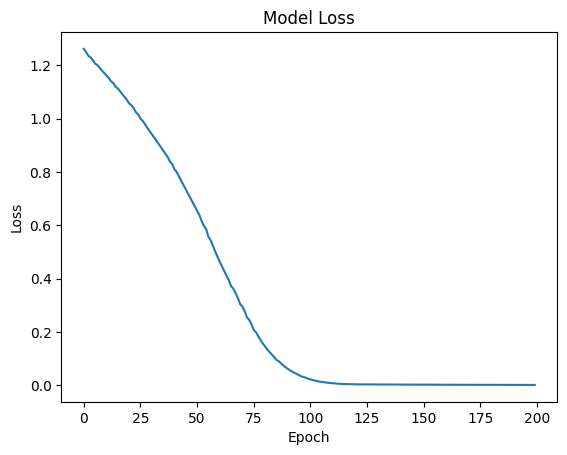

In [52]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Evaluation Metrics
* MAE (Mean Absolute Error)

* RMSE (Root Mean Squared Error)

* MAPE (Mean Absolute Percentage Error)

* R² Score

In [53]:
# Make predictions on the test set
y_pred = model.predict(X_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


In [54]:
# Inverse transform the scaled predictions and actual values to the original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

In [55]:
# Calculate evaluation metrics on the original scale
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

Calculate MAPE

In [56]:
# Calculate MAPE (handle division by zero if necessary)
# A common approach is to use a small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + epsilon))) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 4.83
Root Mean Squared Error (RMSE): 6.40
Mean Absolute Percentage Error (MAPE): 0.46%
R-squared (R²): 0.99
